In [1]:
import os

import torch
from PIL import Image
from pipelines.inverted_ve_pipeline import create_image_grid
from pipelines.pipeline_stable_diffusion_xl import StableDiffusionXLPipeline
from utils import init_latent, memory_efficient, torch_gc


2024-05-12 00:16:15.794393: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 00:16:15.859736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 00:16:15.859791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 00:16:15.859826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 00:16:15.871922: I tensorflow/core/platform/cpu_feature_g

In [2]:

def create_number_list(n):
    return list(range(n + 1))


def create_nested_list(t):
    return [[0, t]]


def create_prompt(style_name):
    pre_prompt_dicts = {
        "kids drawing": (
            "kids drawing of {prompt}. crayon, colored pencil, marker",
            "",
        ),
        "self portrait": ("{prompt} of van gogh", ""),
        "Sunflowers": ("{prompt} of van gogh", ""),
        "The kiss": ("{prompt} of gustav klimt", ""),
        "Vitruvian Man": ("{prompt} of leonardo da vinci", ""),
        "Weeping woman": ("{prompt} of pablo picasso", ""),
        "The scream": ("{prompt} of edvard munch", ""),
        "The starry night": ("{prompt} of van gogh", ""),
        "Starry night over the rhone": ("{prompt} of van gogh", ""),
        "MOVIE": ("{prompt} movie poster", ""),
    }

    if style_name in pre_prompt_dicts.keys():
        return pre_prompt_dicts[style_name]
    else:
        return ("{prompt}", "")  # base_prompt, negative_prompt


In [3]:
from dataclasses import dataclass


@dataclass
class Arguments:
    tar_obj: str = "a dog and a man" # target object
    guidance_scale: float = 7.0
    output_num: int = 4
    activate_step: int = 50
    results_dir: str = "./results"

In [4]:
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler

args = Arguments()
tar_seeds = create_number_list(args.output_num)
activate_step_indices = create_nested_list(args.activate_step)


pipe = StableDiffusionXLPipeline.from_pretrained(
    # "RunDiffusion/Juggernaut-X-v10",
    # torch_dtype=torch_dtype,
    # variant="fp16",
    "SG161222/RealVisXL_V4.0_Lightning", 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
)
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
        pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++"
)
pipe.to('cuda')

str_activate_layer, str_activate_step = pipe.activate_layer(
    activate_layer_indices=[[0, 0], [128, 140]],
    attn_map_save_steps=[],
    activate_step_indices=activate_step_indices,
    use_shared_attention=False,
)

/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
torch_gc()

gc: collected=177 {'ram': {'used': 7.11, 'total': 502.56}, 'gpu': {'used': 13.49, 'total': 23.65}, 'retries': 0, 'oom': 0}


In [6]:
from diffusers.utils import load_image


tar_obj = args.tar_obj
guidance_scale = args.guidance_scale

with torch.no_grad():
    hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
    real_img = load_image(hf_dataset_base_url + '1.jpg')

    style_name = "MOVIE"
    latents = []

    base_prompt, negative_prompt = create_prompt(style_name)
    ref_prompt = base_prompt.replace("{prompt}", style_name)
    inf_prompt = base_prompt.replace("{prompt}", tar_obj)

    for tar_seed in tar_seeds:
        latents.append(
            init_latent(
                model=pipe, img=real_img, device_name="cuda", dtype=torch.float32, seed=tar_seed
            )
        )

    latents = torch.cat(latents, dim=0)
    torch_gc()
    images = pipe(
        prompt=ref_prompt,
        guidance_scale=7,
        latents=latents,
        num_images_per_prompt=len(tar_seeds),
        target_prompt=inf_prompt,
        use_inf_negative_prompt=False,
        use_advanced_sampling=False,
        use_prompt_as_null=True,
        image=real_img,
        height=512,
        width=512,
    )[0]
    torch_gc()
    # [real image, fake1, fake2, ... ]
    save_path = os.path.join(args.results_dir, "{}_{}.png".format(style_name, tar_obj))

    n_row = 1
    n_col = len(tar_seeds)
    grid = create_image_grid(images, n_row, n_col)

    grid.save(save_path)
    print(f"saved to {save_path}")


gc: collected=127 {'ram': {'used': 7.11, 'total': 502.56}, 'gpu': {'used': 13.5, 'total': 23.65}, 'retries': 0, 'oom': 0}


  0%|          | 0/50 [00:00<?, ?it/s]

Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  0
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  1
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  2
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  3
Inference Step:  4
Inference Step:  4
Inference Step:  4
Inference Step:  4
Inference St

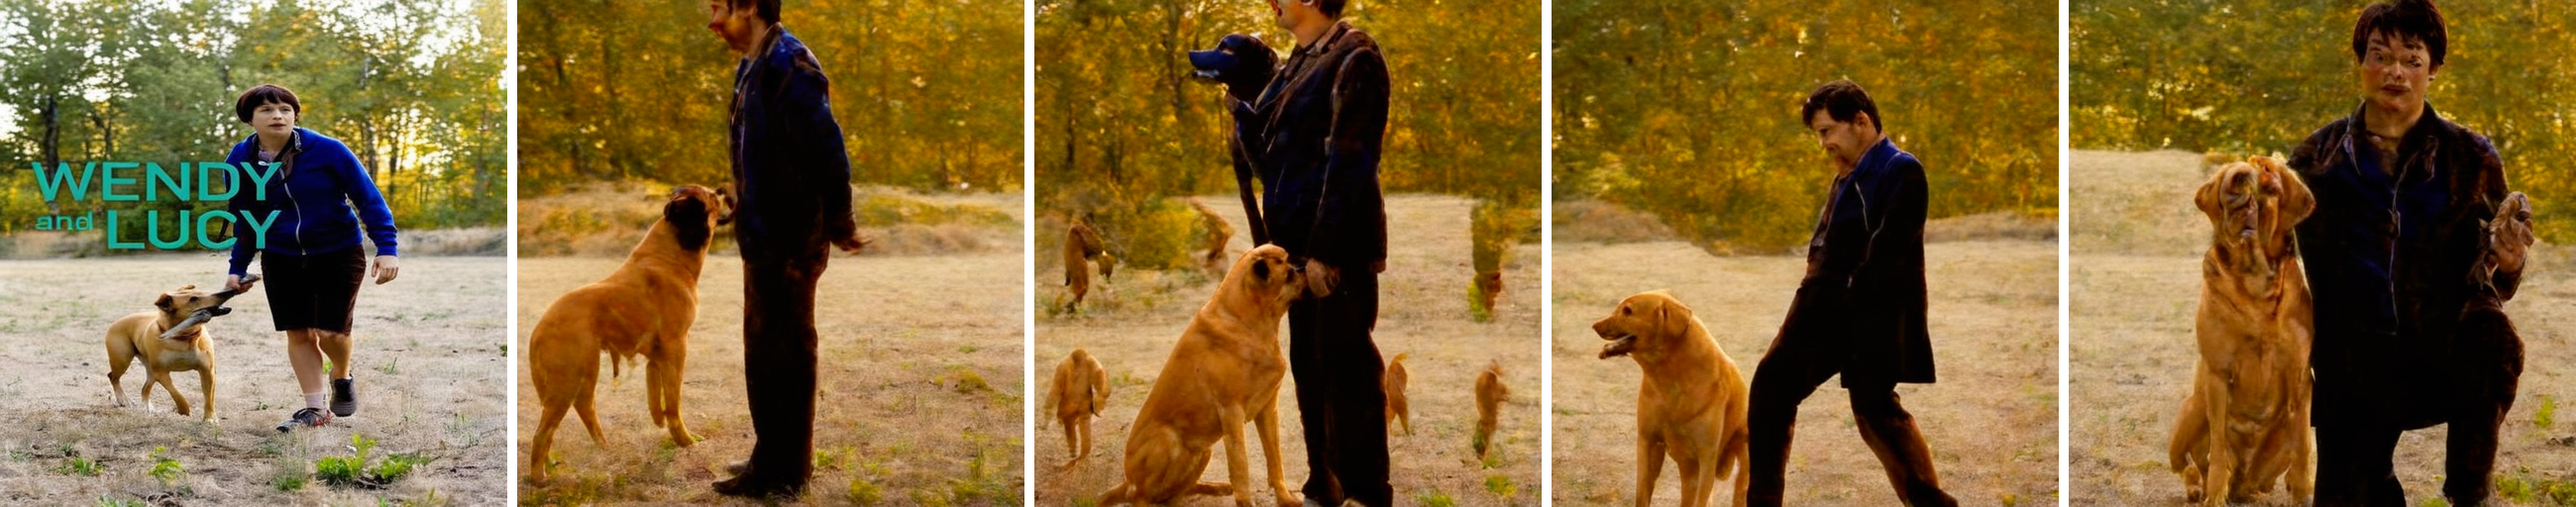

In [7]:
display(grid)